<a href="https://colab.research.google.com/github/GJanos/image-classification/blob/main/hazi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install:**

In [ ]:
!pip install torch torchvision numpy matplotlib seaborn scikit-learn

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Define device based on availability so program runs better
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using {device} device")

Using cuda device


**Step 1: Load and Preprocess the Data**

I chose the Kuzushiji-MNIST (KMNIST) dataset, because it is a challenging variant of the classic MNIST dataset, designed for machine learning and image classification tasks. It comprises 70,000 grayscale images of 28x28 pixels each, featuring 10 classes of handwritten Japanese cursive characters (Kuzushiji). The dataset is split into 60,000 training images and 10,000 testing images, mirroring the structure of the original MNIST.

I processed the data in 64 sized batches.

In [6]:
# Define transformations: convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and transform the KMNIST training dataset
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Load and transform the KMNIST test dataset
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



**Step 2: Build the CNN Model**

Model 1 has 2 layers.

Model 2 has 3 layers.

Model 3 has 7 layers.

I wanted to see if adding more inner layers could increase the accuracy of the model, after seeing the results I realized that having well tested and calculated non redundent number of layers/connections is the way to achieve the best results.

Out of all of these the "simplest" model 1 seemed to be the best performer. This is probably due to the simplicity of the task and the dataset.

In [8]:
#model 1
# Define the KMNISTNet class as a subclass of nn.Module for creating a CNN model
class KMNISTNet(nn.Module):
    def __init__(self):
        super(KMNISTNet, self).__init__()
        # Define two convolutional layers with ReLU activation
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 input channel, 32 output channels, kernel size 3, stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # 32 input channels, 64 output channels, kernel size 3, stride 1

        # Define dropout layers to reduce overfitting
        self.dropout1 = nn.Dropout2d(0.25)  # Dropout 25% of the neurons
        self.dropout2 = nn.Dropout2d(0.5)   # Dropout 50% of the neurons

        # Define fully connected layers for classification
        self.fc1 = nn.Linear(9216, 128)  # Flatten layer outputs to 128 neurons
        self.fc2 = nn.Linear(128, 10)    # Map from 128 neurons to 10 output classes

    def forward(self, x):
        # Define the forward pass through the network
        x = F.relu(self.conv1(x))  # Apply ReLU activation after first convolution
        x = F.relu(self.conv2(x))  # Apply ReLU activation after second convolution
        x = F.max_pool2d(x, 2)     # Apply max pooling with a 2x2 window
        x = self.dropout1(x)       # Apply first dropout layer
        x = torch.flatten(x, 1)    # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))    # Apply ReLU activation after first fully connected layer
        x = self.dropout2(x)       # Apply second dropout layer
        x = self.fc2(x)            # Output layer with 10 classes
        output = F.log_softmax(x, dim=1)  # Apply log softmax to the output
        return output

# Instantiate the model and move it to the specified device (GPU or CPU)
model = KMNISTNet().to(device)


The sigmoid function is a valid choice for an activation function, its usage in deep networks is less common compared to ReLU or LeakyReLU, especially in CNNs. This is due to the vanishing gradient problem, where gradients can become very small, effectively slowing down or halting the training process.

This seems to be really the case since when trying that the result were really bad, only hitting ~10% accuracy even with lr=0.001 and a more rash lr=0.01 too.

Relu type activation function performed much better.

In [10]:
#model 2
class KMNISTNet2(nn.Module):
    def __init__(self, activation_fn=F.relu):
        super(KMNISTNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.activation_fn(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout2(x)
        x = self.activation_fn(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

# Example usage with ReLU
model_relu = KMNISTNet2(activation_fn=F.relu).to(device) # ~94% accuracy

# Example usage with LeakyReLU
model_leaky_relu = KMNISTNet2(activation_fn=F.leaky_relu).to(device) # ~95% accuracy

model_sigmoid = KMNISTNet2(activation_fn=torch.sigmoid).to(device) # ~10% accuracy


Checket whether more inner layers result in better accuracy. It turns out sometimes less is more, since it performed worse than the previous cases ~93% accuracy.

In [12]:
#model 3
class KMNISTNet3(nn.Module):
    def __init__(self, activation_fn=F.relu):
        super(KMNISTNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Reduce the size of layers gradually
        self.fc1 = nn.Linear(9216, 256)  # Increased size for the first FC layer
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)    # Additional layers
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 10)     # Output layer, 10 classes for KMNIST

        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.activation_fn(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout2(x)
        x = self.activation_fn(self.fc2(x))
        x = self.activation_fn(self.fc3(x))
        x = self.activation_fn(self.fc4(x))
        x = self.activation_fn(self.fc5(x))
        x = self.activation_fn(self.fc6(x))
        x = self.fc7(x)
        output = F.log_softmax(x, dim=1)
        return output

model_many_layers = KMNISTNet3(activation_fn=F.relu).to(device) # ~93% accuracy

**lr=0.1** ~10% accuraccy


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309150

Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.300713

Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.304933

Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.300706

Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.293551

Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.302729

Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.306099

Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.305542

Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.296490

Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.303093

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304554

**lr=0.001 with weight_decay=1e-5** ~94% accuraccy


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302792

Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.817670

Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.451665

Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.240180

Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.345797

Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.324835

Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.345400

Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.184844

Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.205408

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.270808

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.222320



**lr=0.0001** ~90% accuraccy

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306234

Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.993224

Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.922818

Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.980614

Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.681750

Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.568745

Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.560671

Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.651193

Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.463013

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.513719

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.708901


**Step 3: Set up Loss Function and Optimizer**

Above you can see model 1 tried out with many different lr values and their performance.

**Loss Function (nn.CrossEntropyLoss) **

This line initializes the Cross-Entropy Loss, which is commonly used in classification tasks. Cross-Entropy Loss measures the performance of a classification model whose output is a probability value between 0 and 1. It is particularly well-suited for multi-class classification problems like the KMNIST dataset, where it effectively penalizes the model for incorrect classifications and for being uncertain about its predictions.

 **Optimizer (optim.Adam): **

Here, the Adam optimizer is chosen to optimize the model's parameters. The learning rate of 0.001 is a common default value for Adam, providing a good balance between speed and accuracy in many scenarios.



In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


I achieved the best results with lr being 0.001, which converged quite fast towards a pretty stable ~95% accurracy. That number being high enough I was satisfied with it.

**Step 4: Train the Model**


Here I test the model against the training dataset to see how it reacts to new data, and see if the model overfits or not.
Within each epoch, the inner loop iterates over the dataset in mini-batches, as provided by trainloader. Batching is crucial in training neural networks as it makes the training process more efficient and can also help with generalization.

In [ ]:
epochs = 5

# Track metrics
train_losses = []
train_accuracies = []

# Iterate over each epoch
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    # Iterate over each batch in the training data
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)  # Move the data and labels to the current device (GPU/CPU)

        optimizer.zero_grad()  # Reset gradients for this training step

        output = model(data)  # Forward pass: compute the model output

        loss = criterion(output, target)  # Compute the loss value

        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t model parameters

        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Print training status every 100 batches
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.6f}')

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)


**Step 5: Evaluate the Model**

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track the test loss and the number of correct predictions
test_loss = 0
correct = 0

# No gradient calculations needed during testing
with torch.no_grad():
    for data, target in testloader:
        # Move data to the appropriate device (GPU or CPU)
        data, target = data.to(device), target.to(device)

        # Forward pass through the model to get predictions
        output = model(data)

        # Calculate the batch loss
        test_loss += criterion(output, target).item()  # Sum up batch loss

        # Get the index of the max log-probability (the predicted class index)
        pred = output.argmax(dim=1, keepdim=True)

        # Count how many predictions match the true labels
        correct += pred.eq(target.view_as(pred)).sum().item()

# Average the total loss by the total number of items in the dataset
test_loss /= len(testloader.dataset)

# Calculate the accuracy as a percentage
accuracy = 100. * correct / len(testloader.dataset)

# Print out the performance metrics
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(testloader.dataset)} ({accuracy:.0f}%)')


Test set: Average loss: 0.0030, Accuracy: 9468/10000 (95%)


**Step 6: Visualizing model**


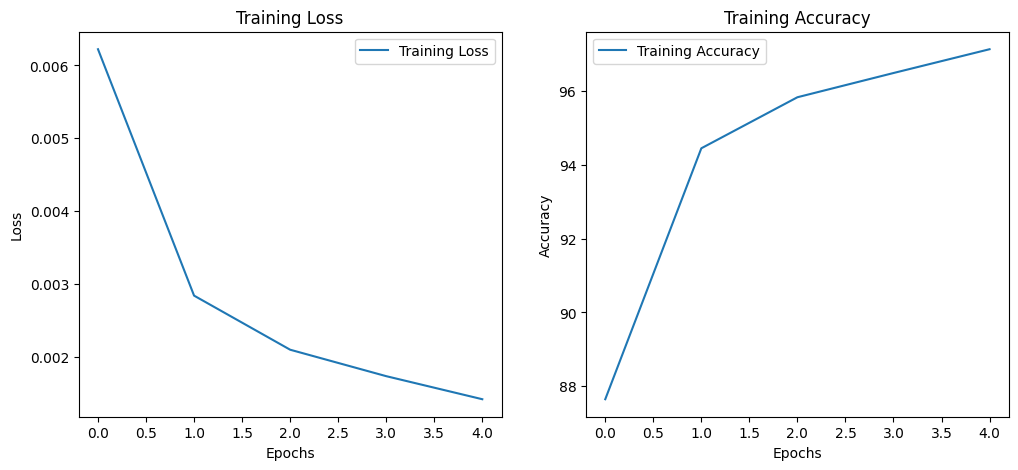

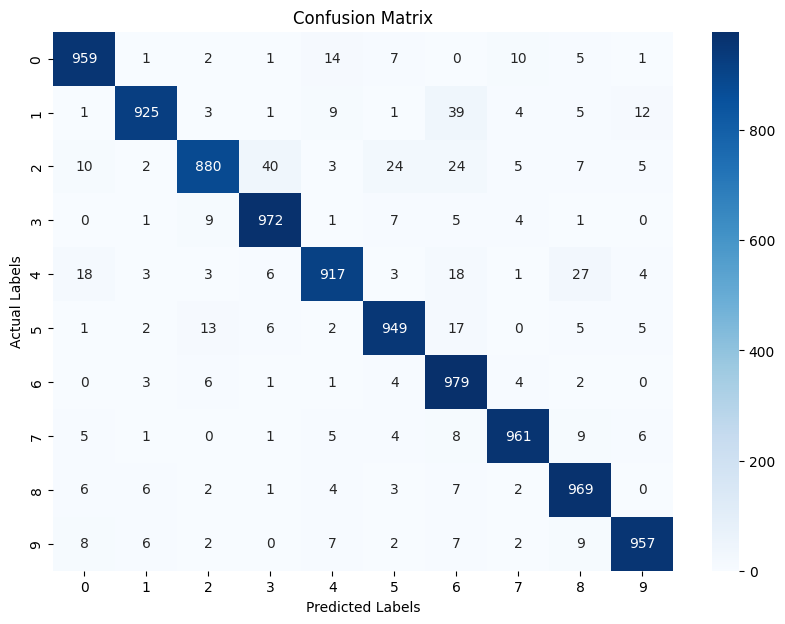

In [16]:
# Testing loop for confusion matrix
all_preds = []
all_targets = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for data, target in testloader:
        data, target = data.to(device), target.to(device)  # Move data and labels to the current device
        outputs = model(data)  # Forward pass to get the model outputs
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
        all_preds.extend(predicted.view(-1).cpu().numpy())  # Collect all predictions
        all_targets.extend(target.view(-1).cpu().numpy())  # Collect all true labels

conf_matrix = confusion_matrix(all_targets, all_preds)  # Compute the confusion matrix

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()